In [1]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import librosa
import librosa.display
import librosa.feature
import IPython.display as ipd
from sklearn.svm import SVC

In [2]:
x = np.load('../Part1.npy')
Y_t = np.load('../train.npy/y_train.npy')
#X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../Part2.npy')
Y_test = np.load('../test.npy/Y_Test.npy')
#X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))
x_add = np.load('../Part3.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
#x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))
Y_train = np.concatenate((Y_t, Y_test, y_add))
X_train = np.concatenate((x, xt, x_add))
#X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [3]:
X_test = np.load('X_single.npy')
Y_test = np.load('Y_single.npy')

In [4]:
import warnings
warnings.filterwarnings("ignore")
svm = SVC(C=0.15, tol=0.041, kernel='poly', coef0=0.79, degree=6)
chains = [ClassifierChain(svm, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_max = Y_pred_chains.max(axis=0)

In [5]:
Y_pred_ensemble = Y_pred_chains.mean(axis=0)
Y_pred = np.where(Y_pred_ensemble>0.5,1,0)
m = multilabel_confusion_matrix(Y_test, Y_pred)
print(m)

[[[6316    1]
  [ 387    1]]

 [[ 129 6071]
  [   5  500]]

 [[6254    0]
  [ 451    0]]

 [[  73 5995]
  [  34  603]]

 [[5945    0]
  [ 760    0]]

 [[6023    0]
  [ 682    0]]

 [[5984    0]
  [ 721    0]]

 [[   0 6079]
  [   0  626]]

 [[5026 1102]
  [ 461  116]]

 [[6125    0]
  [ 580    0]]

 [[   0 5927]
  [   0  778]]]


In [6]:
tp = sum(m[:,1,1])
fp = sum(m[:,0,1])
tn = sum(m[:,0,0])
fn = sum(m[:,1,0])
print(tp, fp, tn, fn)

2624 25175 41875 4081


In [7]:
precision = np.array([x[1,1]/(x[1,1]+x[0,1]) for x in m])
recall = np.array([x[1,1]/(x[1,1]+x[1,0]) for x in m])
f1 = 2*precision*recall/(precision+recall)
print(precision)

[0.5        0.07609192        nan 0.09139133        nan        nan
        nan 0.09336316 0.0952381         nan 0.11603281]


In [8]:
recall

array([0.00257732, 0.99009901, 0.        , 0.9466248 , 0.        ,
       0.        , 0.        , 1.        , 0.20103986, 0.        ,
       1.        ])

In [9]:
f1

array([0.00512821, 0.14132278,        nan, 0.1666897 ,        nan,
              nan,        nan, 0.17078161, 0.12924791,        nan,
       0.20793799])

In [10]:
ovr = OneVsRestClassifier(svm)
ovr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=SVC(C=0.15, coef0=0.79, degree=6, kernel='poly',
                                  tol=0.041))

In [11]:
ovr_pred = ovr.predict(X_test)

In [12]:
M_ovr = multilabel_confusion_matrix(Y_test, ovr_pred)

In [13]:
M_ovr

array([[[6317,    0],
        [ 388,    0]],

       [[5616,  584],
        [ 498,    7]],

       [[6254,    0],
        [ 451,    0]],

       [[  80, 5988],
        [  37,  600]],

       [[5945,    0],
        [ 760,    0]],

       [[6003,   20],
        [ 676,    6]],

       [[5984,    0],
        [ 721,    0]],

       [[   0, 6079],
        [   0,  626]],

       [[3966, 2162],
        [ 301,  276]],

       [[6125,    0],
        [ 580,    0]],

       [[   0, 5927],
        [   0,  778]]])

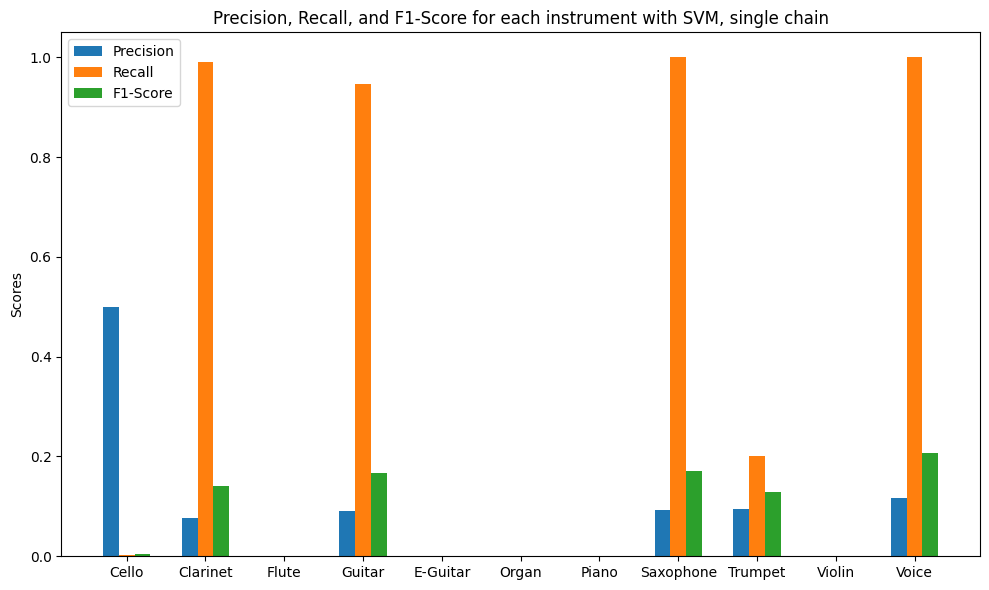

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x_ax = ["Cello","Clarinet", "Flute", "Guitar", "E-Guitar", "Organ", "Piano", "Saxophone", "Trumpet", "Violin", "Voice"]
x = np.arange(len(precision))  # the label locations
width = 0.2  # the width of the bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for each instrument with SVM, single chain')
ax.set_xticks(x)
ax.set_xticklabels([i for i in x_ax])
ax.legend()
fig.tight_layout()
plt.savefig('ScoresSVMsingle.png')
plt.show()